<a href="https://colab.research.google.com/github/uribo1008/azure-openai-test/blob/main/B4_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. テキストデータの収集

### 1-1. 【授業中は実行しません】　スクレイピング

**すごく時間がかかるので授業中はここを実行せず取得済みのテキストデータを利用します！！**

ここではYahoo!知恵袋からQ&Aのテキストデータをスクレイピングで取得します。
以下のように実行すると指定されたカテゴリの質問と回答のテキストをスクレイピングします。

```
text = get_yahoo_chiebukuro_text(カテゴリ)
```

「カテゴリ」としては以下のようなものを登録しています。
- 恋愛相談
- 大学受験
- 住宅

Yahoo!知恵袋のカテゴリIDが分かれば

なお，過剰な負荷を避けるために以下のような配慮をしています。
- 一度に取得する回答の数は最大60？（10ページ分）
- １ページ分の回答をスクレイピングするたびにほんの少し休みます。

**↓うっかりクリックして実行しないように！！！**

In [ ]:
# 必要なパッケージの読み込み
import requests
import re
import time
import random
from bs4 import BeautifulSoup

MAIN_SORT_KEY = {"更新日時の新しい順":16, "更新日時の古い順": 17, "質問日時の新しい順":20, "質問日時の古い順":21, "回答数の多い順":4, "回答数の少ない順":5, "お礼の多い順":8}
DETAIL_SORT_KEY={"ナイスの多い順":0, "新しい順":1, "古い順":2}
QA_STAT = {"回答受付中": 0, "解決済み": 1, "全て": 3}

def get_qa_text(base_link, sort_mode="ナイスの多い順"):
  text_list = []
  sort_id = DETAIL_SORT_KEY[sort_mode]
  link = base_link + "?sort={}".format(sort_id)

  res = requests.get(link)
  soup = BeautifulSoup(res.text.encode(res.encoding), "html.parser")

  ans_count_tag = soup.select_one('strong[class*="Chie-QuestionItem__AnswerNumber__"]')
  ans_count = int("".join(ans_count_tag.text.split(","))) if ans_count_tag is not None else 0
  max_page = min(10, (ans_count // 10 + 1) if 0 < ans_count else 1)

  print(f"*** QA: # of answers:{ans_count}, pages:{max_page} ... ")

  print("**** extracting Question ... ", end = "")
  #que_text_tag = soup.select_one('div[class*="Chie-QuestionItem__Text__"]')
  que_text_tag = soup.find("div", class_=re.compile(r"Chie-QuestionItem__Text__"))
  if que_text_tag is not None:
    text_list.append(que_text_tag.text)
  print("done.")

  for page_num in range(1, max_page+1):
    print(f"**** extracting Answers in page {page_num} ... ", end="")
    page_link = link + "&page={}".format(page_num)

    # 過剰な負荷を避けるため，１ページ分の記事を取得する前に 1〜3秒休む
    time.sleep(random.randrange(1, 3))

    res = requests.get(link)
    soup = BeautifulSoup(res.text.encode(res.encoding), "html.parser")

    # ans_text_list = soup.select('div[class*="Chie-AnswerItem__ItemText__"]')
    ans_text_list = soup.find_all("div", class_=re.compile(r"Chie-AnswerItem__ItemText__"))
    ans_text_num = 0
    for ans_tag in ans_text_list:
      text_list.append(ans_tag.text)
      ans_text_num += 1
    print(f"{ans_text_num} answers extracted.")

  return "".join(text_list)


def get_qa_link_list(url):
  qa_link_list = []

  # 過剰な負荷を避けるため，１ページ分のリンクリストを取得する前に 1〜3秒休む
  time.sleep(random.randrange(1, 3))

  res = requests.get(url)
  soup = BeautifulSoup(res.text.encode(res.encoding), "html.parser")
  qa_list = soup.find("div", {"id": "qa_lst"})
  qa_atag_list = qa_list.find_all("a")
  for qa_atag in qa_atag_list:
    qa_link_list.append(qa_atag["href"])
  return qa_link_list


def get_yahoo_chiebukuro_text(category_id, sort_mode="回答数の多い順", qa_stat="解決済み", max_qa_num = 10, page_count=1):
  base_url = "https://chiebukuro.yahoo.co.jp/category/{}/question/list?flg={}&sort={}&page={}"
  sort_id = MAIN_SORT_KEY[sort_mode]
  qa_stat_id = QA_STAT[qa_stat]

  print("* launching the process ... ")
  qa_link_list = []
  for page in range(1, page_count+1):
    print(f"** retrieving QA links from page #{page} ... ", end = "")
    url = base_url.format(category_id, qa_stat_id, sort_id, page)
    qa_link_list_sub = get_qa_link_list(url)
    qa_link_list.extend(qa_link_list_sub)
    print(f"{len(qa_link_list_sub)} links retrieved.")
    if max_qa_num < len(qa_link_list):
      break

  # 指定された個数までのQ&Aしか取得しない（デフォルトでは10）
  qa_link_list = qa_link_list[:max_qa_num]

  text_list = []
  for qa_link in qa_link_list:
    print(f"** retrieving QA from {qa_link} ... ")
    text_list.append(get_qa_text(qa_link))
    print("** retrieving QA done.")
  print("* done.")

  return "".join(text_list)

In [ ]:
# 誤って実行しないようにコメントアウトしています。実行したい場合は行頭の # を取り除いてください。
# CATEGORY = {"恋愛相談": 2078675272, "大学受験": 2079405665, "住宅": 2078297940, "話題の人物":2078297579}
# text = get_yahoo_chiebukuro_text(CATEGORY["話題の人物"])
#調べるときはYAHOO知恵袋のカテゴリから選択した落ちにURLに含まれている数字を持ってい来る必要がある。

### 1-1. 【授業中はこちらを実行】 テキストデータのアップロード

テキストデータをスクレイピングで取得する代わりに，取得済みのテキストデータをアップロードして利用します。

先週の資料に従って，BEEF+からテキストデータをダウンロードし，Google Colaboratoryのセッションストレージにアップロードしてください。

In [4]:
# 以下では大学受験の記事（yc_univ_2018.txt)を利用
with open("yc_univ_2024.txt", "r") as f:
  text = f.read()

### 1-2. テキストの確認

取得した（または読み込んだ）テキストデータを確認します。


In [5]:
text

'共通テスト終わりました。誰にも言えないのでここに思いや疑問を書かせていただきます。\nはっきり言って勉強不足でした。もっと頑張れたしなんであそこで勉強サボったんだろう。気づいたら共通テストまであと1日でした。\n 僕は文系だったので正直なめてました。易化する場合もあるし気楽に行こうと思い、1日目受けてみると得意だった英語や国語など文系科目が難化していて自分が得意だったところがピンポイントでほとんど難化してました。\n 難化を言い訳にするなんてダサいのは分かってるのにどうしても言い訳に逃げてしまいます。\n 周りの友達も難化の影響を受けてても勉強に後悔してることはなくある程度の点数は取るんだろうなと思って羨ましく、自分の中ですごくモヤモヤしてます。\n はっきり言ってこんなにダメなのに僕は少しだけ学歴コンプです。学歴が高く就職に就くのに憧れてるし、本音で言うと周りの人達よりも少し上にいたい。こんな考えはひどいと思いますが、それも勉強のモチベの一つでした。まだ判定は出てませんがはっきり言って偏差値50程度の私立文系しかもう残されてません。途中(高2？)までは高い点数を取って少し優越感的なものもあったのに今は絶望感しかありません。\n そんなに思うなら浪人すればいいと思うかもしれませんが、僕は浪人にあまり良いイメージがありません。周りの友達が進学したり遊んだりして、学校へも行かずにただ自分一人で勉強して1年遅く大学に入るのはとても想像できません。\n 浪人するぐらいならその1年を満喫したいと思ってしまうのです。全てにおいて大学受験をなめていて考えが甘いのはわかっています。\n でもどうしても第一志望に行きたいです。第一志望の共通テストと2次の割合は50：50でかなり共通テストが重要です。僕の自己採点は最低点から40-50程度低くとても2次で挽回できると思えなく、2次まで頑張っても意味があるのか分かりません。おそらくE判定です。\n はぁこの1年ほんとに頑張れたのかな。なんでスマホ見ちゃう時間があったんだろ。これを見てる高校2年生はこんな思いしてほしくない。しっかり今の時期から頑張って欲しい。当たり前すぎてアドバイスにもならないですよね。。\n 親にいい思いさせたかった。あまり裕福な家庭でもないしもっと褒めてくれるような結果が欲しかった。僕は落ちこぼれです。こんな僕は2次

## 2. クレンジング

テキストデータに含まれる不要なデータを取り除きます。

上記で確認したように，今回のテキストデータはスクレイピングの際にHTMLタグなどは除去しているので，あまり不要なデータがありません。

今回は改行コードやタブ文字などの余分な空白文字を取り除くという処理だけ行います。場合によってはアルファベットの大文字小文字や全角半角の変換も必要かもしれません。

### 2-1. クレンジング用の関数定義

In [6]:
import re

# クレンジング用の関数定義
def cleansing(text):
  clean_text = re.sub("\s", "", text)  # 余分な空白の除去
  return clean_text

### 2-2. クレンジングの実行

In [7]:
clean_text = cleansing(text)

### 2-3. テキストの確認

クレンジング後のテキストを確認します

In [8]:
clean_text

'共通テスト終わりました。誰にも言えないのでここに思いや疑問を書かせていただきます。はっきり言って勉強不足でした。もっと頑張れたしなんであそこで勉強サボったんだろう。気づいたら共通テストまであと1日でした。僕は文系だったので正直なめてました。易化する場合もあるし気楽に行こうと思い、1日目受けてみると得意だった英語や国語など文系科目が難化していて自分が得意だったところがピンポイントでほとんど難化してました。難化を言い訳にするなんてダサいのは分かってるのにどうしても言い訳に逃げてしまいます。周りの友達も難化の影響を受けてても勉強に後悔してることはなくある程度の点数は取るんだろうなと思って羨ましく、自分の中ですごくモヤモヤしてます。はっきり言ってこんなにダメなのに僕は少しだけ学歴コンプです。学歴が高く就職に就くのに憧れてるし、本音で言うと周りの人達よりも少し上にいたい。こんな考えはひどいと思いますが、それも勉強のモチベの一つでした。まだ判定は出てませんがはっきり言って偏差値50程度の私立文系しかもう残されてません。途中(高2？)までは高い点数を取って少し優越感的なものもあったのに今は絶望感しかありません。そんなに思うなら浪人すればいいと思うかもしれませんが、僕は浪人にあまり良いイメージがありません。周りの友達が進学したり遊んだりして、学校へも行かずにただ自分一人で勉強して1年遅く大学に入るのはとても想像できません。浪人するぐらいならその1年を満喫したいと思ってしまうのです。全てにおいて大学受験をなめていて考えが甘いのはわかっています。でもどうしても第一志望に行きたいです。第一志望の共通テストと2次の割合は50：50でかなり共通テストが重要です。僕の自己採点は最低点から40-50程度低くとても2次で挽回できると思えなく、2次まで頑張っても意味があるのか分かりません。おそらくE判定です。はぁこの1年ほんとに頑張れたのかな。なんでスマホ見ちゃう時間があったんだろ。これを見てる高校2年生はこんな思いしてほしくない。しっかり今の時期から頑張って欲しい。当たり前すぎてアドバイスにもならないですよね。。親にいい思いさせたかった。あまり裕福な家庭でもないしもっと褒めてくれるような結果が欲しかった。僕は落ちこぼれです。こんな僕は2次を頑張っても受かるのでしょうか。見ての通り受かるかどうかだ

In [9]:
len(clean_text)


186984

## 3. トークン化

以下では形態素解析パッケージを利用して，テキストデータをトークン（ここでは形態素）に分割，分ち書きのテキスト（空白でトークンを区切ったテキスト）に変換します。


### 3-1. 形態素パッケージのインストール

作業に先立って授業資料の［補足1］を見てください。

In [10]:
!pip install janome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 69.0 MB/s eta 0:00:00


### 3-2. トークン化用の関数定義


In [11]:
from janome.tokenizer import Tokenizer

def wakati(text, accept_pos=["名詞", "動詞"]):
  punctuations = ["。", ".", ".", "？", "?", "！", "!"]
  tokenizer = Tokenizer()
  tokens = tokenizer.tokenize(text)
  sentence_list = []
  token_list = []
  for token in tokens:
    pos = token.part_of_speech.split(",")[0]
    if token.surface in punctuations and 0 < len(token_list):
      sentence_list.append(" ".join(token_list)) # トークンを空白で繋げる
      token_list = []
    elif len(accept_pos) == 0 or pos in accept_pos:
      token_list.append(token.surface)
  if 0 < len(token_list):
    sentence_list.append(" ".join(token_list)) # トークンを空白で繋げる
  return "\n".join(sentence_list) # センテンスごとに改行で分ける

### 3-3. トークン化してみる

Janomeが遅いのですごく時間がかかる可能性があります。

In [12]:
wakati_text = wakati(clean_text, accept_pos=[]) #[]の中に名詞と入力したら名詞だけを抜粋できる。

### 3-4. テキストの確認

分ち書きされたテキストデータを確認します。

In [13]:
wakati_text

'共通 テスト 終わり まし た\n誰 に も 言え ない ので ここ に 思い や 疑問 を 書か せ て いただき ます\nはっきり 言っ て 勉強 不足 でし た\nもっと 頑張れ たしなん で あそこ で 勉強 サボっ た ん だろ う\n気づい たら 共通 テスト まで あと 1 日 でし た\n僕 は 文系 だっ た ので 正直 なめ て まし た\n易化 する 場合 も ある し 気楽 に 行こ う と 思い 、 1 日 目 受け て みる と 得意 だっ た 英語 や 国語 など 文系 科目 が 難 化 し て い て 自分 が 得意 だっ た ところ が ピン ポイント で ほとんど 難 化 し て まし た\n難 化 を 言い訳 に する なんて ダサい の は 分かっ てる のに どうしても 言い訳 に 逃げ て しまい ます\n周り の 友達 も 難 化 の 影響 を 受け て て も 勉強 に 後悔 し てる こと は なく ある程度 の 点数 は 取る ん だろ う な と 思っ て 羨ましく 、 自分 の 中 で すごく モヤモヤ し て ます\nはっきり 言っ て こんなに ダメ な のに 僕 は 少し だけ 学歴 コンプ です\n学歴 が 高く 就職 に 就く の に 憧れ てる し 、 本音 で 言う と 周り の 人達 より も 少し 上 に い たい\nこんな 考え は ひどい と 思い ます が 、 それ も 勉強 の モチベ の 一つ でし た\nまだ 判定 は 出 て ませ ん が はっきり 言っ て 偏差 値 50 程度 の 私立 文系 しか もう 残さ れ て ませ ん\n途中 ( 高 2 ？) まで は 高い 点数 を 取っ て 少し 優越 感 的 な もの も あっ た のに 今 は 絶望 感 しか あり ませ ん\nそんなに 思う なら 浪人 すれ ば いい と 思う かも しれ ませ ん が 、 僕 は 浪人 に あまり 良い イメージ が あり ませ ん\n周り の 友達 が 進学 し たり 遊ん だり し て 、 学校 へ も 行か ず に ただ 自分 一 人 で 勉強 し て 1 年 遅く 大学 に 入る の は とても 想像 でき ませ ん\n浪人 する ぐらい なら その 1 年 を 満喫 し たい

### 3-5. テキストの保存

一旦，分ち書きされたテキストデータを保存します。

保存したあと更新してみてください。うまく保存されている場合，左のストレージペインにファイルが表示されます。

In [14]:
with open("yc_univ_2024_wakati.txt", "w") as f:
  f.write(wakati_text)

## 4. Word2Vecしてみる

保存された分ち書きテキストデータを使ってWord2Vecを学習させてみます。

### 4-1. Word2Vecを学習する

In [15]:
from gensim.models import word2vec

# 保存された分ち書きテキストのファイル名を指定
sentences = word2vec.LineSentence("yc_univ_2024_wakati.txt")

# Word2Vecを学習
# vector_size：ベクトルの次元（トークンの数にもよるが100〜300くらい）
# min_count：最小出現回数
# window：どれぐらい周辺の単語を考慮するか
model = word2vec.Word2Vec(sentences, vector_size=100, min_count=10, window=10)

### 4-2. Word2Vecのテスト

In [16]:
model.wv.most_similar(positive="合格", topn=10, restrict_vocab=10000)

[('発表', 0.9616379141807556),
 ('型', 0.9424079656600952),
 ('有名', 0.9371532797813416),
 ('東京学芸大学', 0.9359516501426697),
 ('なんで', 0.9357426762580872),
 ('大', 0.9346758723258972),
 ('時', 0.9327618479728699),
 ('新卒', 0.9326887726783752),
 ('受け', 0.9325975775718689),
 ('結局', 0.9261378049850464)]

In [17]:
v = model.wv["大学"] - model.wv["高校"]
model.wv.most_similar(positive=[v], topn=10)

[('大学', 0.7614139914512634),
 ('東京学芸大学', 0.7547883987426758),
 ('非常', 0.7475918531417847),
 ('強く', 0.7407475113868713),
 ('勧め', 0.7405017614364624),
 ('働かせる', 0.7397378087043762),
 ('不幸', 0.7384030818939209),
 ('都内', 0.7326121926307678),
 ('せる', 0.7287141680717468),
 ('普通', 0.7260201573371887)]

### 4-3. 学習済みモデルの保存

あとで読み込んで再利用できるように学習済みモデルを保存します。

In [19]:
model.save("yc_univ_2024.model")

## 5. トークン空間をプロットしてみる

PCAを使ってトークン・ベクトルの次元を低次元化し，プロットしてみる。

### 5.1 日本語プロット用パッケージのインストール

In [20]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 39.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=564cf8db7339316ae49f7d18975d7989207257297c026b918f9a7f33ce30347e
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


### 5.2 プロット用の関数定義

In [21]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import japanize_matplotlib

def get_converter(x):
    converter = PCA(random_state=0)
    converter.fit(x)
    return converter


def make_plot(model, pca=(0,1), num = 200, min_word_len = 4, width = 10, height = 10, font_size = 14):
    vocab = model.wv.index_to_key
    emb_tuple = tuple([model.wv[v] for v in vocab])
    converter = get_converter(np.vstack(emb_tuple))

    plt.rcParams["font.size"] = font_size
    fig = plt.figure(figsize=(width, height))  # 図のサイズ
    cmap = ["red", "blue", "green", "magenta", "black", "cyan", "yellow"]

    for i, v in enumerate([vocab]):
        available_vocab = []
        orig_pos = []
        for j in range(len(v)):
            if min_word_len <= len(v[j]) and len(available_vocab) < num:
                p = model.wv[v[j]]
                available_vocab.append(v[j])
                orig_pos.append(p)

        if 0 < len(orig_pos):
            emb_pos = converter.transform(orig_pos)
            marker = [2 for _ in range(len(emb_pos))]
            plt.scatter(emb_pos[:, pca[0]], emb_pos[:, pca[1]], s=marker, c=cmap[i % len(cmap)])
            for label, x, y in zip(available_vocab, emb_pos[:, pca[0]], emb_pos[:, pca[1]]):
                plt.annotate(label, xy=(x, y), xytext=(3, -2), textcoords='offset points')
    return fig

### 5.3 プロットの実行

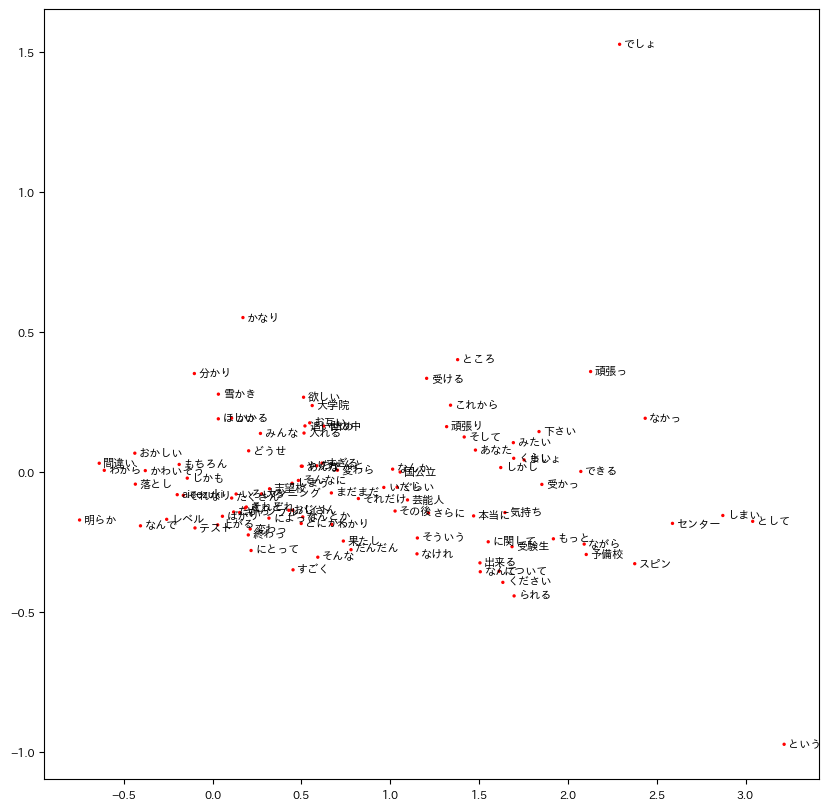

In [27]:
fig = make_plot(model, pca=(0,1), num = 100, min_word_len = 3, font_size=8)